# Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import sklearn as sk
import statistics as st
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD

In [2]:
winLoss = pd.read_csv('winners.csv', names=['Win/Loss'])
words1000 = pd.read_csv('mostfreq1000word.csv', encoding='cp1252', names=['Tag'])
speeches = pd.read_csv('speeches.csv', names=['Speech'])
decepWords = pd.read_csv('deceptionword.csv', names=['Words'])
decepWordCount = pd.read_csv('deceptiondocword.csv', names=decepWords['Words'].tolist())
wordRates = pd.read_csv('mostfreq1000docword.csv', names=words1000['Tag'].tolist())
wordsAndTags = pd.read_csv('mostfreq1000word.csv', delimiter='_', encoding='cp1252', names=['Word', 'Tag'])


# Data Exploration
## Correlations - Word Usage Rates Etc.

In [3]:
df1 = pd.concat([winLoss, wordRates], axis=1, sort=False)
corrMatrix = df1.corr()
wlCorr = pd.DataFrame(corrMatrix.iloc[0,1:])
wlCorrSorted = wlCorr.sort_values(['Win/Loss'])
corrMatrix.head()

,Win/Loss,the_AT,and_CC,to_TO,of_IN,a_AT,in_IN,we_PPSS,i_PPSS,for_IN,...,equal_JJ,east_NR,walk_VB,morning_NN,decision_NN,led_VBD,september_NP,areas_NNS,outstanding_JJ,streets_NNS
Win/Loss,1.000000,-0.294418,-0.222703,0.132682,-0.313305,0.016004,-0.140568,0.304108,-0.079540,0.045443,...,-0.023477,-0.095534,0.115551,-0.025444,-0.107549,0.137360,0.063342,-0.016419,0.159144,0.124807
the_AT,-0.294418,1.000000,0.278018,-0.188944,0.607511,-0.036065,0.341771,-0.113385,-0.103354,-0.087347,...,-0.081887,0.251515,-0.054609,0.118692,0.059695,0.052396,0.139839,-0.024485,-0.081072,0.077392
and_CC,-0.222703,0.278018,1.000000,-0.350320,0.412078,-0.039177,0.186335,-0.071729,-0.091281,-0.012632,...,-0.035559,0.085341,-0.082285,0.036687,-0.055449,0.189316,0.021153,0.111370,-0.077141,0.119483
to_TO,0.132682,-0.188944,-0.350320,1.000000,-0.346793,-0.092749,-0.163980,0.197217,0.247939,-0.022078,...,-0.054522,-0.158273,0.012579,0.057555,0.068293,-0.107278,0.081090,0.002855,0.026287,-0.030155
of_IN,-0.313305,0.607511,0.412078,-0.346793,1.000000,0.103220,0.324458,-0.168459,-0.239155,-0.160246,...,0.037349,0.205458,-0.052436,0.056394,-0.059528,0.080959,0.021040,0.095490,-0.081375,0.061736


In [4]:
wlCorrSorted.head(50)

,Win/Loss
obama_NP,-0.403759
greater_JJR,-0.354763
government_NN,-0.353634
elected_VBN,-0.333501
of_IN,-0.313305
will_MD,-0.300358
the_AT,-0.294418
among_IN,-0.289292
spending_NN,-0.281609
to_IN,-0.279324


In [5]:
wlCorrSorted.head()

,Win/Loss
obama_NP,-0.403759
greater_JJR,-0.354763
government_NN,-0.353634
elected_VBN,-0.333501
of_IN,-0.313305


In [6]:
posCorrWords = wlCorr[(wlCorr[wlCorr.columns] > 0)].T
posCorrWords = posCorrWords.T
posCorrWords.dropna(inplace=True)
 
negCorrWords = wlCorr[(wlCorr[wlCorr.columns] < 0)].T
negCorrWords = negCorrWords.T
negCorrWords.dropna(inplace=True)

In [7]:
print("Positively Correlated Words:", len(posCorrWords))
print("Negatively Correlated Words:", len(negCorrWords))

Positively Correlated Words: 573
Negatively Correlated Words: 427


In [8]:
words = list(wlCorr[wlCorr.columns].T)
correlations = list(wlCorr['Win/Loss'])
posCorrelations = list(posCorrWords['Win/Loss'])
negCorrelations = list(negCorrWords['Win/Loss'])
wordLen = []*len(words)

#Stripping Stanford suffixes
for i in range(len(words)):
    word, garb = words[i].split('_')
    words[i] = word
    wordLen.append(len(words[i]))
    
def stripSuffix(inputDF):
    inputList = list(inputDF[inputDF.columns].T)
    outWords = []
    outLengths = []
    for i in range(len(inputList)):
        word, garb = inputList[i].split('_')
        outWords.append(word)
        outLengths.append(len(word))     
    return outWords, outLengths

# sum(wordLen)/len(wordLen)
st.stdev(wordLen)

2.227181253588566

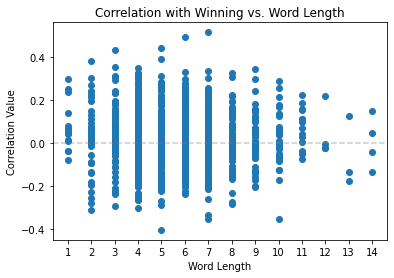

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(wordLen, correlations)

ax.set_title('Correlation with Winning vs. Word Length')
ax.set_xlabel('Word Length')
ax.set_ylabel('Correlation Value')
ax.set_xticks(np.arange(1,15))
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.4)

plt.show()

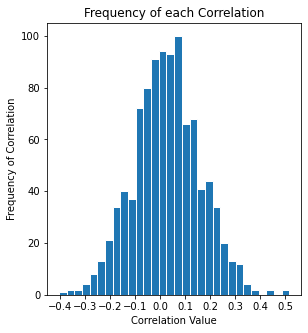

In [10]:
fig = plt.figure(figsize=[10,5])

ax = fig.add_subplot(121)
ax.hist(correlations, bins=30, edgecolor="White")

ax.set_title('Frequency of each Correlation')
ax.set_ylabel('Frequency of Correlation')
ax.set_xlabel('Correlation Value')
ax.set_xticks(np.arange(-0.4, 0.6, 0.1))

plt.show()

In [11]:
tempSer = wlCorr['Win/Loss']
lowCorr = tempSer[tempSer.abs()<0.05]
lowCorrDf = pd.DataFrame(lowCorr.T)
lowCorrWords = lowCorrDf.index.tolist()
# lowCorrWords

highCorr = tempSer[tempSer.abs()>0.05]
highCorrDf = pd.DataFrame(highCorr.T)
highCorrWords = highCorrDf.index.tolist()
# lowCorrWords

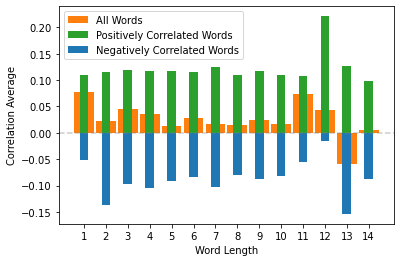

In [12]:
totalList = [[] for k in range(14)]
positiveList = [[] for k in range(14)]
negativeList = [[] for k in range(14)]

avgCorr = [0]*14
avgPosCorr = [0]*14
avgNegCorr = [0]*14
lengths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

for i in range(len(wordLen)):
    totalList[wordLen[i]-1].append(correlations[i])
    
tempWords, tempLengths = stripSuffix(posCorrWords)
    
for i in range(len(tempWords)):
    positiveList[tempLengths[i]-1].append(posCorrelations[i])
    
tempWords, tempLengths = stripSuffix(negCorrWords)
    
for i in range(len(tempWords)):
    negativeList[tempLengths[i]-1].append(negCorrelations[i])

    
for i in range(14):
    avgCorr[i] = sum(totalList[i])/len(totalList[i])
    avgPosCorr[i] = sum(positiveList[i])/len(positiveList[i])
    avgNegCorr[i] = sum(negativeList[i])/len(negativeList[i])
    

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(lengths, avgCorr, label = "All Words", width=0.9, color="tab:orange")
ax.bar(lengths, avgPosCorr, label = "Positively Correlated Words", width=0.4, align='center', color='tab:green')
ax.bar(lengths, avgNegCorr, label = "Negatively Correlated Words", width=0.4, align='center', color='tab:blue')
# ax.xaxis.grid(True)
ax.set_xticks(np.arange(1,15))
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.4)

plt.legend()

ax.set_xlabel('Word Length')
ax.set_ylabel('Correlation Average')

plt.show()

In [13]:
wordsAndTags.head()

,Word,Tag
0,the,AT
1,and,CC
2,to,TO
3,of,IN
4,a,AT


# Tag Analysis

Text(0, 0.5, 'Correlation')

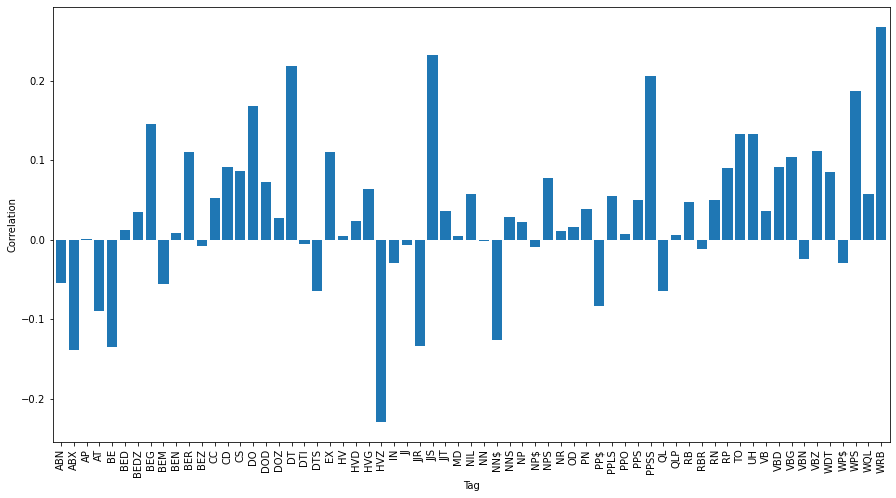

In [14]:
win_tag_corr = wlCorr['Win/Loss']
win_tag_corr.index = wordsAndTags['Tag']
avg_win_tag_corr = win_tag_corr.groupby(level=0).mean()  # mean correlation for each stanford tag
ax = avg_win_tag_corr.plot(kind='bar', figsize=(15,8), width=0.8)
ax.set_xlabel("Tag")
ax.set_ylabel("Correlation")

In [15]:
wordRates4T = pd.read_csv('mostfreq1000docword.csv', header=None)
wordRates4T.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.047838,0.037313,0.021814,0.020475,0.020283,0.020092,0.013586,0.004018,0.010716,0.005549,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000191
1,0.040797,0.031784,0.023482,0.016603,0.022770,0.022533,0.010199,0.011860,0.010199,0.008776,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000237,0.0,0.000000
2,0.037022,0.033041,0.016919,0.018113,0.019904,0.016322,0.013734,0.017914,0.007166,0.009355,...,0.000199,0.000000,0.0,0.0,0.000199,0.0,0.0,0.000000,0.0,0.000398
3,0.053289,0.037926,0.018243,0.024964,0.015362,0.027844,0.012962,0.002880,0.009122,0.007201,...,0.000000,0.000480,0.0,0.0,0.000000,0.0,0.0,0.000480,0.0,0.000000
4,0.051535,0.029605,0.012061,0.026316,0.025219,0.020833,0.002193,0.010965,0.006579,0.006579,...,0.000000,0.002193,0.0,0.0,0.001097,0.0,0.0,0.000000,0.0,0.000000


In [16]:
wordRates4T2 = wordRates4T.T
wordRates4T2 = wordRates4T2.join(wordsAndTags['Tag'])
wordRates4TG = wordRates4T2.groupby(['Tag']).sum()
wordRates4T2

,0,1,2,3,4,5,6,7,8,9,...,422,423,424,425,426,427,428,429,430,Tag
0,0.047838,0.040797,0.037022,0.053289,0.051535,0.049890,0.050786,0.039157,0.048755,0.041090,...,0.028924,0.052405,0.064646,0.062718,0.049268,0.042038,0.036674,0.041244,0.051724,AT
1,0.037313,0.031784,0.033041,0.037926,0.029605,0.029156,0.031299,0.029639,0.029086,0.025599,...,0.034139,0.043410,0.036364,0.029268,0.039281,0.026396,0.026976,0.031104,0.053050,CC
2,0.021814,0.023482,0.016919,0.018243,0.012061,0.027472,0.027914,0.026386,0.023645,0.025379,...,0.018966,0.016425,0.020202,0.014634,0.017643,0.022485,0.026530,0.028569,0.022546,TO
3,0.020475,0.016603,0.018113,0.024964,0.026316,0.023196,0.024829,0.019639,0.024482,0.019886,...,0.014699,0.028158,0.034343,0.026481,0.029627,0.018140,0.017389,0.017843,0.015915,IN
4,0.020283,0.022770,0.019904,0.015362,0.025219,0.015550,0.018133,0.013735,0.018205,0.018677,...,0.016596,0.014861,0.008081,0.016725,0.019308,0.016185,0.019842,0.017453,0.009284,AT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000075,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000111,0.000000,0.001326,VBD
996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NP
997,0.000000,0.000237,0.000000,0.000480,0.000000,0.000389,0.000301,0.000241,0.000209,0.000110,...,0.000474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NNS
998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000075,0.000000,0.000000,0.000000,...,0.000474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,JJ


In [17]:
wordRates4TG = wordRates4TG.T
wordRates4TG

Tag,ABN,ABX,AP,AT,BE,BED,BEDZ,BEG,BEM,BEN,...,VB,VBD,VBG,VBN,VBZ,WDT,WP$,WPS,WQL,WRB
0,0.002105,0.000383,0.009759,0.076540,0.003444,0.000574,0.003444,0.000574,0.000000,0.001722,...,0.041332,0.005740,0.008228,0.003827,0.001531,0.004592,0.000765,0.006506,0.000191,0.003062
1,0.003321,0.000000,0.010674,0.068548,0.005930,0.001423,0.003321,0.000237,0.000000,0.000949,...,0.054554,0.008539,0.009488,0.005455,0.002372,0.011622,0.000000,0.007353,0.000712,0.007827
2,0.005374,0.000398,0.007365,0.066878,0.004777,0.000398,0.002787,0.000597,0.001990,0.000597,...,0.040804,0.008161,0.008360,0.005573,0.002986,0.004777,0.000000,0.006170,0.000199,0.006966
3,0.002880,0.001920,0.005761,0.072492,0.003360,0.001440,0.002400,0.000000,0.000000,0.001440,...,0.026404,0.002880,0.002400,0.003361,0.000960,0.002400,0.000480,0.006721,0.000000,0.004321
4,0.000000,0.000000,0.006579,0.081140,0.003290,0.001097,0.003290,0.000000,0.002193,0.003290,...,0.018641,0.003289,0.002193,0.006579,0.001097,0.004386,0.000000,0.004386,0.000000,0.007676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,0.001997,0.000000,0.006658,0.072904,0.003329,0.003329,0.005659,0.000666,0.000000,0.001664,...,0.028629,0.004993,0.004328,0.003329,0.000999,0.002330,0.000000,0.008988,0.000333,0.004660
427,0.003476,0.000434,0.006843,0.061482,0.003150,0.000869,0.002281,0.000543,0.000109,0.002064,...,0.054204,0.007169,0.015750,0.005540,0.002390,0.005540,0.000000,0.007169,0.000217,0.004236
428,0.003233,0.000446,0.009029,0.060195,0.003456,0.001449,0.007580,0.000780,0.000669,0.002898,...,0.055066,0.010701,0.014491,0.006131,0.002898,0.007914,0.000000,0.007134,0.001226,0.007357
429,0.001755,0.000098,0.005265,0.062305,0.005265,0.001463,0.004485,0.000878,0.010140,0.001755,...,0.045827,0.006045,0.010823,0.005070,0.002048,0.003900,0.000000,0.006630,0.000488,0.003120


## Correlations - Deception

In [18]:
countsD = np.array(decepWordCount.sum(axis=1))
winLossArr = np.array(winLoss['Win/Loss'])
corr = np.corrcoef(countsD, winLossArr)
decepTotCorr = corr[1,0]
print(decepTotCorr)

0.2201984308715195


In [19]:
df2 = pd.concat([winLoss, decepWordCount], axis=1, sort=False)
corrMatrixDecep = df2.corr()
decepWLCorr = pd.DataFrame(corrMatrixDecep.iloc[0,1:])
decepWLCorrSorted = decepWLCorr.sort_values(['Win/Loss'])
# decepWLCorrSorted

In [20]:
# decepWLCorr

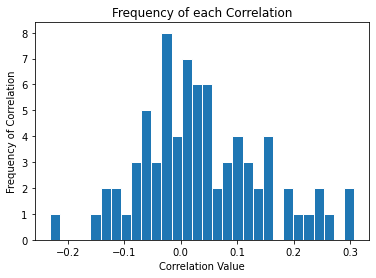

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist( list(decepWLCorr['Win/Loss']), bins=30, edgecolor="white")

ax.set_title('Frequency of each Correlation')
ax.set_ylabel('Frequency of Correlation')
ax.set_xlabel('Correlation Value')

plt.show()

In [22]:
w_len_corr = pd.concat([decepWords['Words'].transform(len), decepWLCorr[1:].reset_index()], axis=1)
w_len_corr = w_len_corr.drop('index', axis=1)
w_len_corr.columns = ['Word Length', 'Corr']

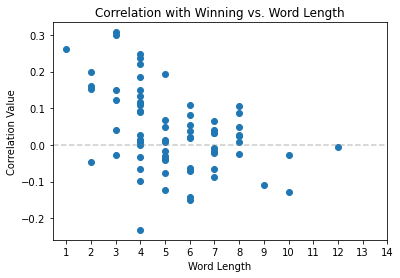

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(w_len_corr['Word Length'], w_len_corr['Corr'])

ax.set_title('Correlation with Winning vs. Word Length')
ax.set_xlabel('Word Length')
ax.set_ylabel('Correlation Value')
ax.set_xticks(np.arange(1,15))
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.4)

plt.show()

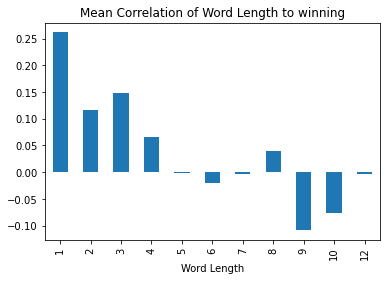

In [24]:
a = w_len_corr.groupby(['Word Length']).mean()
a.plot(kind='bar', title='Mean Correlation of Word Length to winning', legend=False)

In [25]:
countsDDf = pd.DataFrame(countsD, columns=['Total Count'])
decepWordCount = decepWordCount.join(countsDDf)
normalizedDecepCount=(decepWordCount-decepWordCount.min())/(decepWordCount.max()-decepWordCount.min()) 
# minmax normalisation
normalizedDecepCount.head()

,i,but,or,my,going,me,i'm,go,take,i've,...,lied,agony,ignorant,fled,despise,inferior,boring,dislike,anguish,Total Count
0,0.106061,0.287879,0.261905,0.169811,0.122807,0.193548,0.030303,0.225806,0.111111,0.217391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209979
1,0.252525,0.378788,0.285714,0.113208,0.280702,0.709677,0.303030,0.645161,0.055556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.380457
2,0.454545,0.621212,0.404762,0.584906,0.140351,0.483871,0.060606,0.161290,0.333333,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.488565
3,0.030303,0.106061,0.119048,0.094340,0.000000,0.032258,0.000000,0.032258,0.055556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056133
4,0.050505,0.106061,0.000000,0.018868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041580


In [56]:
tempSerD = decepWLCorr['Win/Loss']
lowCorrD = tempSerD[tempSerD.abs()<0.05]
lowCorrDfD = pd.DataFrame(lowCorrD.T)
lowCorrWordsD = lowCorrDfD.index.tolist()

highCorrD = tempSerD[tempSerD.abs()>0.05]
highCorrDfD = pd.DataFrame(highCorrD.T)
highCorrWordsD = highCorrDfD.index.tolist()
lowCorrWordsD
len(lowCorrWordsD)

33

# Preparing Prediction Data


In [27]:
winLoss = pd.read_csv('winners.csv', names=['Win/Loss'])
words1000 = pd.read_csv('mostfreq1000word.csv', encoding='cp1252', names=['Tag'])
speeches = pd.read_csv('speeches.csv', names=['Speech'])
decepWords = pd.read_csv('deceptionword.csv', names=['Words'])
decepWordCount = pd.read_csv('deceptiondocword.csv', names=decepWords['Words'].tolist())
wordRates2 = pd.read_csv('mostfreq1000docword.csv', names=words1000['Tag'].tolist())

In [28]:
speeches.head()

,Speech
0,1992clinton920416.txt
1,1992clinton920422.txt
2,1992clinton920716.txt
3,1992clinton920814.txt
4,1992clinton921002.txt


In [29]:
yearList = []
nameList = []
speechNumList = []

for row in speeches["Speech"]:
    yearList.append(row[0:4])
    
    numRow = row[4:]
    numRow, suffix = numRow.split(".")
    for i in range(len(numRow)):
        if not numRow[i].isalpha():
            speechNumList.append(numRow[i:])
            break
    
    row, suffix = row.split(".")
    row = row[:-1]
    if("debate" in row):
        temp = "".join(re.findall("[a-zA-Z]+", row))
        nameList.append(temp[:-6])
    else:
        nameList.append("".join(re.findall("[a-zA-Z]+", row)))


## DF Assembly

In [30]:
yearSer = pd.Series(yearList).T
nameSer = pd.Series(nameList).T
speechNumSer = pd.Series(speechNumList).T

tempDf = pd.DataFrame({'Candidate':nameSer, 'Election':yearSer, 'Speech ID':speechNumSer})
wordsFullDf = winLoss.join(tempDf)
wordsFullDf = wordsFullDf.join(wordRates)
wordsFullDf.columns[1000]

'september_NP'

In [31]:
# wordsFullDf.to_csv(r'fullWordData.csv', index=False)

In [32]:
stopwords = nltk.corpus.stopwords.words('english')
wordsNoStopDf = wordsFullDf.copy()

In [33]:
for colName in wordsNoStopDf.columns:
    if("_" in colName):
        tempName, suffix = colName.split("_")
        if(tempName in stopwords):
            wordsNoStopDf = wordsNoStopDf.drop([colName], axis=1)

wordsNoStopDf.head()

,Win/Loss,Candidate,Election,Speech ID,people_NNS,america_NP,that's_DT,make_VB,president_NN,country_NN,...,equal_JJ,east_NR,walk_VB,morning_NN,decision_NN,led_VBD,september_NP,areas_NNS,outstanding_JJ,streets_NNS
0,1,clinton,1992,920416,0.003062,0.003253,0.000191,0.002679,0.002296,0.003062,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000191
1,1,clinton,1992,920422,0.011148,0.001423,0.001898,0.001898,0.002372,0.005218,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000237,0.0,0.000000
2,1,clinton,1992,920716,0.005772,0.007564,0.002388,0.002190,0.002588,0.003782,...,0.000199,0.000000,0.0,0.0,0.000199,0.0,0.0,0.000000,0.0,0.000398
3,1,clinton,1992,920814,0.000960,0.000960,0.000000,0.002400,0.004321,0.000480,...,0.000000,0.000480,0.0,0.0,0.000000,0.0,0.0,0.000480,0.0,0.000000
4,1,clinton,1992,921002,0.005483,0.000000,0.000000,0.000000,0.008772,0.000000,...,0.000000,0.002193,0.0,0.0,0.001097,0.0,0.0,0.000000,0.0,0.000000


In [34]:
winLossDfFinal = pd.DataFrame(wordsFullDf['Win/Loss'], columns=['Win/Loss'])
referenceColsFinal = wordsNoStopDf[['Candidate', 'Election', 'Speech ID']]
wordsNoStopDfFinal = wordsNoStopDf.drop(['Win/Loss','Candidate', 'Election', 'Speech ID'], axis=1)
wordsFullDfFinal = wordsFullDf.drop(['Win/Loss','Candidate', 'Election', 'Speech ID'], axis=1)
wordsHighCorrDfFinal = wordsFullDf.drop(['Win/Loss','Candidate', 'Election', 'Speech ID'], axis=1)
wordsHighCorrDfFinal = wordsHighCorrDfFinal.drop(lowCorrWords, axis=1)
sTagRatesDfFinal = wordRates4TG
normalizedDecepCountDfFinal = normalizedDecepCount.copy()
normalizedDecepCountHighCorrDfFinal = normalizedDecepCountDfFinal.drop(lowCorrWordsD, axis=1)
combinedNormalizedHighCorrDfFinal = ((wordsHighCorrDfFinal-wordsHighCorrDfFinal.min())/(wordsHighCorrDfFinal.max()-wordsHighCorrDfFinal.min())).join(normalizedDecepCountHighCorrDfFinal)

wordsLowCorrDfFinal = wordsFullDf.drop(['Win/Loss','Candidate', 'Election', 'Speech ID'], axis=1)
wordsLowCorrDfFinal = wordsLowCorrDfFinal.drop(highCorrWords, axis=1)
normalizedDecepCountDfFinal = normalizedDecepCount.copy()
normalizedDecepCountLowCorrDfFinal = normalizedDecepCountDfFinal.drop(highCorrWordsD, axis=1)


In [35]:
tempDf7 = referenceColsFinal.join(wordsFullDfFinal)
print(tempDf7.shape)
commonWords = tempDf7.groupby(['Election']).sum()
commonWords

(431, 1003)


,the_AT,and_CC,to_TO,of_IN,a_AT,in_IN,we_PPSS,i_PPSS,for_IN,is_BEZ,...,equal_JJ,east_NR,walk_VB,morning_NN,decision_NN,led_VBD,september_NP,areas_NNS,outstanding_JJ,streets_NNS
Election,,,,,,,,,,,,,,,,,,,,,
1992,0.230481,0.169669,0.092519,0.106471,0.103538,0.107624,0.052674,0.047638,0.043781,0.037460,...,0.000199,0.002673,0.000000,0.000000,0.001296,0.000000,0.000000,0.000717,0.000000,0.000589
1994,0.617080,0.398431,0.322105,0.309731,0.214756,0.246897,0.211888,0.160588,0.135217,0.109223,...,0.000830,0.001504,0.002142,0.000771,0.001487,0.001136,0.000000,0.002701,0.000287,0.002349
1996,1.562132,1.192095,0.845685,0.748375,0.663551,0.611550,0.511406,0.558667,0.326071,0.334892,...,0.000156,0.000555,0.004823,0.004907,0.007226,0.000726,0.000661,0.004474,0.003046,0.010230
2000,0.920514,0.629246,0.454287,0.520384,0.396264,0.313476,0.271180,0.288557,0.207706,0.201308,...,0.007721,0.000302,0.000430,0.002628,0.000889,0.000291,0.000249,0.003534,0.000000,0.000761
2002,0.578970,0.454611,0.331972,0.347844,0.244070,0.202140,0.182870,0.149924,0.129693,0.174036,...,0.000784,0.001374,0.000688,0.001844,0.000575,0.000220,0.004608,0.000462,0.000000,0.000000
2004,1.217425,0.851151,0.659015,0.565521,0.493813,0.425487,0.370479,0.325753,0.303247,0.277393,...,0.001284,0.005883,0.001391,0.006008,0.004732,0.002053,0.015126,0.002469,0.000000,0.001522
2008,8.090816,6.660154,3.969719,4.554056,3.322003,3.239472,2.663810,2.087681,2.124007,1.638660,...,0.027904,0.014995,0.012946,0.021713,0.017040,0.032103,0.010279,0.024554,0.001913,0.022215
2010,1.135433,0.949302,0.626429,0.636175,0.467679,0.423880,0.363144,0.253642,0.282648,0.221022,...,0.001954,0.000459,0.001526,0.005942,0.002101,0.006074,0.002209,0.004484,0.014278,0.002362
2012,3.655223,2.811294,2.212083,1.742554,1.640695,1.449053,1.480760,1.173495,0.949777,0.928287,...,0.012470,0.007842,0.014452,0.010145,0.008612,0.006296,0.002163,0.003300,0.025453,0.001979


In [36]:
countSer = commonWords.astype(bool).sum(axis=0)
cw2 = wordsFullDfFinal.copy()
cwout = wordsFullDfFinal.copy()

for col in countSer.index:
    if(countSer[col] > 5):
        cw2.drop([col], axis=1, inplace=True)
    if(countSer[col] < 5):
        cwout.drop([col], axis=1, inplace=True)

wordsInMT4Speeches = cwout.copy()      
cwout

,the_AT,and_CC,to_TO,of_IN,a_AT,in_IN,we_PPSS,i_PPSS,for_IN,is_BEZ,...,equal_JJ,east_NR,walk_VB,morning_NN,decision_NN,led_VBD,september_NP,areas_NNS,outstanding_JJ,streets_NNS
0,0.047838,0.037313,0.021814,0.020475,0.020283,0.020092,0.013586,0.004018,0.010716,0.005549,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000191
1,0.040797,0.031784,0.023482,0.016603,0.022770,0.022533,0.010199,0.011860,0.010199,0.008776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000237,0.0,0.000000
2,0.037022,0.033041,0.016919,0.018113,0.019904,0.016322,0.013734,0.017914,0.007166,0.009355,...,0.000199,0.000000,0.000000,0.000000,0.000199,0.000000,0.0,0.000000,0.0,0.000398
3,0.053289,0.037926,0.018243,0.024964,0.015362,0.027844,0.012962,0.002880,0.009122,0.007201,...,0.000000,0.000480,0.000000,0.000000,0.000000,0.000000,0.0,0.000480,0.0,0.000000
4,0.051535,0.029605,0.012061,0.026316,0.025219,0.020833,0.002193,0.010965,0.006579,0.006579,...,0.000000,0.002193,0.000000,0.000000,0.001097,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,0.049268,0.039281,0.017643,0.029627,0.019308,0.015646,0.006658,0.009321,0.008988,0.007989,...,0.000000,0.001332,0.000000,0.000333,0.000000,0.000000,0.0,0.000000,0.0,0.000000
427,0.042038,0.026396,0.022485,0.018140,0.016185,0.013578,0.010319,0.016511,0.010645,0.012057,...,0.000000,0.000109,0.000000,0.000000,0.000109,0.000000,0.0,0.000000,0.0,0.000000
428,0.036674,0.026976,0.026530,0.017389,0.019842,0.016052,0.009809,0.019507,0.010367,0.010367,...,0.000000,0.000223,0.000000,0.000000,0.000111,0.000111,0.0,0.000000,0.0,0.000000
429,0.041244,0.031104,0.028569,0.017843,0.017453,0.015601,0.021743,0.015991,0.005655,0.010140,...,0.000000,0.001072,0.000293,0.000000,0.000098,0.000000,0.0,0.000000,0.0,0.000293


# Final Data for Prediction

In [37]:
# winLossDfFinal.head()
# referenceColsFinal.head()
# wordsFullDfFinal.head()
# wordsNoStopDfFinal.head()
# wordsHighCorrDfFinal.head() #>5% Correlation
# sTagRatesDfFinal.head()
# normalizedDecepCountDfFinal.head()
# normalizedDecepCountHighCorrDfFinal.head()
# combinedNormalizedHighCorrDfFinal.head()

# normalizedDecepCountLowCorrDfFinal.head()
# wordsInMT4Speeches.head()


#Could add more normalised versions

In [38]:
combinedNormalizedHighCorrDfFinal.head()

,the_AT,and_CC,to_TO,of_IN,in_IN,we_PPSS,i_PPSS,is_BEZ,to_IN,that_CS,...,crazy,jerk,arrive,suspicious,worthless,arrives,vain,despise,dislike,Total Count
0,0.426254,0.588241,0.383208,0.307770,0.703871,0.385845,0.095692,0.154129,0.335778,0.107787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209979
1,0.328788,0.443575,0.420932,0.203869,0.789385,0.289654,0.282428,0.316797,0.178781,0.207159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.380457
2,0.276533,0.476465,0.272502,0.244388,0.571799,0.390049,0.426595,0.345985,0.260988,0.218511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.488565
3,0.501710,0.604281,0.302446,0.428226,0.975442,0.368124,0.068595,0.237406,0.508143,0.151278,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056133
4,0.477430,0.386562,0.162632,0.464506,0.729830,0.062282,0.261115,0.206036,0.494852,0.153938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041580


In [39]:
wordsFullDf.to_csv(r'FinalSheets/fullWordData.csv', index=False)
referenceColsFinal.to_csv(r'FinalSheets/dfReferenceCols.csv', index=False)
wordsFullDfFinal.to_csv(r'FinalSheets/wordsFullDfFinal.csv', index=False)
wordsNoStopDfFinal.to_csv(r'FinalSheets/wordsNoStopDfFinal.csv', index=False)
wordsHighCorrDfFinal.to_csv(r'FinalSheets/wordsHighCorrDfFinal.csv', index=False) #>5% Correlation
sTagRatesDfFinal.to_csv(r'FinalSheets/sTagRatesDfFinal.csv', index=False)
normalizedDecepCountDfFinal.to_csv(r'FinalSheets/normalizedDecepCountDfFinal.csv', index=False)
normalizedDecepCountHighCorrDfFinal.to_csv(r'FinalSheets/normalizedDecepCountHighCorrDfFinal.csv', index=False)
combinedNormalizedHighCorrDfFinal.to_csv(r'FinalSheets/combinedNormalizedHighCorrDfFinal.csv', index=False)
winLossDfFinal.to_csv(r'FinalSheets/winLossDfFinal.csv', index=False)


wordsLowCorrDfFinal.to_csv(r'FinalSheets/wordsLowCorrDfFinal.csv', index=False)
normalizedDecepCountLowCorrDfFinal.to_csv(r'FinalSheets/normalizedDecepCountLowCorrDfFinal.csv', index=False)
wordsInMT4Speeches.to_csv(r'FinalSheets/wordsInMT4SpeechesFinal.csv', index=False)

# Report Garb